# Notebook 2

**Notebook 2 = Downstream task only**

* load precomputed H-optimus embeddings
* aggregate patch embeddings per WSI
* train a lightweight classifier on train split only
* evaluate on validation / test splits

# CAMELYON WSI CLASSIFICATION WITH H-OPTIMUS EMBEDDINGS

**Setup and Data Loading**

In [10]:
import torch
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

**Set random seeds**

In [3]:
np.random.seed(42)
torch.manual_seed(42)

**Load precomputed H-optimus embeddings**

In [4]:
data = torch.load("/kaggle/input/embeddings/hoptimus_patch_embeddings.pt")
embeddings = data["embeddings"]  # shape: [16800, 1536]
meta_rows = data["metadata"]
meta_df = pd.DataFrame(meta_rows)

print(f"✓ Loaded embeddings: {embeddings.shape}")
print(f"✓ Columns: {meta_df.columns.tolist()}")
print(f"\n{meta_df.head()}")

✓ Loaded embeddings: torch.Size([16800, 1536])
✓ Columns: ['patch_id', 'wsi_id', 'label', 'split']

                   patch_id      wsi_id  label  split
0  normal_074_x54016_y69888  normal_074      0  train
1  normal_074_x18688_y74496  normal_074      0  train
2  normal_074_x48640_y75776  normal_074      0  train
3  normal_074_x50688_y75776  normal_074      0  train
4  normal_074_x50944_y75776  normal_074      0  train


**Group patches by WSI**

In [5]:
wsi_embeddings = defaultdict(list)
wsi_labels = {}
wsi_splits = {}

for i, row in meta_df.iterrows():
    wsi_id = row["wsi_id"]
    wsi_embeddings[wsi_id].append(embeddings[i])
    wsi_labels[wsi_id] = row["label"]
    wsi_splits[wsi_id] = row["split"]

print(f"✓ Grouped into {len(wsi_embeddings)} WSIs")
print(f"\nWSI-level split distribution:")
for split in ['train', 'val', 'test']:
    split_wsis = [wsi for wsi, s in wsi_splits.items() if s == split]
    normal = sum(1 for wsi in split_wsis if wsi_labels[wsi] == 0)
    tumor = sum(1 for wsi in split_wsis if wsi_labels[wsi] == 1)
    print(f"  {split}: {len(split_wsis)} WSIs (Normal: {normal}, Tumor: {tumor})")

✓ Grouped into 56 WSIs

WSI-level split distribution:
  train: 39 WSIs (Normal: 17, Tumor: 22)
  val: 8 WSIs (Normal: 3, Tumor: 5)
  test: 9 WSIs (Normal: 4, Tumor: 5)


***Method 1: Mean Pooling + Logistic Regression***

In [11]:

print("METHOD 1: MEAN POOLING + LOGISTIC REGRESSION")

# Aggregate using mean pooling
X, y, splits = [], [], []
for wsi_id, feats in wsi_embeddings.items():
    feats = torch.stack(feats)
    wsi_feat = feats.mean(dim=0)
    X.append(wsi_feat)
    y.append(int(wsi_labels[wsi_id]))
    splits.append(wsi_splits[wsi_id])

X = torch.stack(X).numpy()
y = np.array(y)
splits = np.array(splits)

# Split data
X_train = X[splits == "train"]
y_train = y[splits == "train"]
X_val = X[splits == "val"]
y_val = y[splits == "val"]
X_test = X[splits == "test"]
y_test = y[splits == "test"]

# Train logistic regression with different C values
method1_results = []
for C in [0.001, 0.01, 0.1, 1.0]:
    clf = LogisticRegression(C=C, max_iter=1000, random_state=42)
    clf.fit(X_train, y_train)
    
    val_pred = clf.predict_proba(X_val)[:, 1]
    test_pred = clf.predict_proba(X_test)[:, 1]
    test_pred_binary = (test_pred > 0.5).astype(int)
    
    val_auc = roc_auc_score(y_val, val_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    test_acc = accuracy_score(y_test, test_pred_binary)
    test_precision = precision_score(y_test, test_pred_binary, zero_division=0)
    test_recall = recall_score(y_test, test_pred_binary, zero_division=0)
    
    method1_results.append({
        'method': f'Mean Pooling + LogReg (C={C})',
        'val_auc': val_auc,
        'test_auc': test_auc,
        'test_acc': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall
    })
    
    print(f"C={C}: Val AUC={val_auc:.4f}, Test AUC={test_auc:.4f}, Acc={test_acc:.4f}, Prec={test_precision:.4f}, Rec={test_recall:.4f}")

METHOD 1: MEAN POOLING + LOGISTIC REGRESSION
C=0.001: Val AUC=0.4000, Test AUC=0.4500, Acc=0.5556, Prec=0.5556, Rec=1.0000
C=0.01: Val AUC=0.2667, Test AUC=0.4000, Acc=0.3333, Prec=0.3333, Rec=0.2000
C=0.1: Val AUC=0.1333, Test AUC=0.3500, Acc=0.2222, Prec=0.0000, Rec=0.0000
C=1.0: Val AUC=0.0667, Test AUC=0.2500, Acc=0.2222, Prec=0.0000, Rec=0.0000


***Method 2: Max Pooling + Logistic Regression***

In [12]:
#Method 2: Max Pooling + Logistic Regression

print("METHOD 2: MAX POOLING + LOGISTIC REGRESSION")

# Aggregate using max pooling
X_max = []
for wsi_id, feats in wsi_embeddings.items():
    feats = torch.stack(feats)
    wsi_feat = feats.max(dim=0)[0]
    X_max.append(wsi_feat)

X_max = torch.stack(X_max).numpy()
X_max_train = X_max[splits == "train"]
X_max_val = X_max[splits == "val"]
X_max_test = X_max[splits == "test"]

# Train
clf = LogisticRegression(C=0.001, max_iter=1000, random_state=42)
clf.fit(X_max_train, y_train)

val_pred = clf.predict_proba(X_max_val)[:, 1]
test_pred = clf.predict_proba(X_max_test)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method2_result = {
    'method': 'Max Pooling + LogReg',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}

print(f"Val AUC={method2_result['val_auc']:.4f}, Test AUC={method2_result['test_auc']:.4f}, Acc={method2_result['test_acc']:.4f}, Prec={method2_result['test_precision']:.4f}, Rec={method2_result['test_recall']:.4f}")

METHOD 2: MAX POOLING + LOGISTIC REGRESSION
Val AUC=0.4000, Test AUC=0.4000, Acc=0.5556, Prec=0.5556, Rec=1.0000


***Method 3: Multi-Feature Aggregation (Mean + Max + Std)***

In [13]:
#Method 3: Multi-Feature Aggregation

print("METHOD 3: MULTI-FEATURE AGGREGATION (Mean + Max + Std)")

# Combine multiple statistics
X_multi = []
for wsi_id, feats in wsi_embeddings.items():
    feats = torch.stack(feats)
    mean_feat = feats.mean(dim=0)
    max_feat = feats.max(dim=0)[0]
    std_feat = feats.std(dim=0)
    combined = torch.cat([mean_feat, max_feat, std_feat])
    X_multi.append(combined)

X_multi = torch.stack(X_multi).numpy()

# Normalize
scaler = StandardScaler()
X_multi_train = scaler.fit_transform(X_multi[splits == "train"])
X_multi_val = scaler.transform(X_multi[splits == "val"])
X_multi_test = scaler.transform(X_multi[splits == "test"])
print(f"Feature dimension: {X_multi_train.shape[1]}")

# Train
clf = LogisticRegression(C=0.001, max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(X_multi_train, y_train)

val_pred = clf.predict_proba(X_multi_val)[:, 1]
test_pred = clf.predict_proba(X_multi_test)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method3_result = {
    'method': 'Multi-feature + LogReg',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}

print(f"Val AUC={method3_result['val_auc']:.4f}, Test AUC={method3_result['test_auc']:.4f}, Acc={method3_result['test_acc']:.4f}, Prec={method3_result['test_precision']:.4f}, Rec={method3_result['test_recall']:.4f}")

METHOD 3: MULTI-FEATURE AGGREGATION (Mean + Max + Std)
Feature dimension: 4608
Val AUC=0.4000, Test AUC=0.3500, Acc=0.4444, Prec=0.5000, Rec=0.2000


***Method 4: Random Forest***

In [14]:
#Method 4: Random Forest

print("METHOD 4: MEAN POOLING + RANDOM FOREST")
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

val_pred = clf.predict_proba(X_val)[:, 1]
test_pred = clf.predict_proba(X_test)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method4_result = {
    'method': 'Mean Pooling + Random Forest',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}

print(f"Val AUC={method4_result['val_auc']:.4f}, Test AUC={method4_result['test_auc']:.4f}, Acc={method4_result['test_acc']:.4f}, Prec={method4_result['test_precision']:.4f}, Rec={method4_result['test_recall']:.4f}")

METHOD 4: MEAN POOLING + RANDOM FOREST
Val AUC=0.2333, Test AUC=0.4250, Acc=0.4444, Prec=0.5000, Rec=0.4000


***Method 5: SVM with Normalization***

In [17]:
#Method 5: SVM with Normalization
print("METHOD 5: NORMALIZED MEAN POOLING + SVM")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

clf = SVC(C=1.0, kernel='rbf', probability=True, random_state=42, class_weight='balanced')
clf.fit(X_train_scaled, y_train)

val_pred = clf.predict_proba(X_val_scaled)[:, 1]
test_pred = clf.predict_proba(X_test_scaled)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method5_result = {
    'method': 'Normalized + SVM',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}
print(f"Val AUC={method5_result['val_auc']:.4f}, Test AUC={method5_result['test_auc']:.4f}, Acc={method5_result['test_acc']:.4f}, Prec={method5_result['test_precision']:.4f}, Rec={method5_result['test_recall']:.4f}")

METHOD 5: NORMALIZED MEAN POOLING + SVM
Val AUC=0.1667, Test AUC=0.4500, Acc=0.5556, Prec=0.6000, Rec=0.6000


***Method 6: SMOTE + Logistic Regression***

In [18]:
#Method 6: SMOTE + Logistic Regression

print("METHOD 6: SMOTE OVERSAMPLING + LOGISTIC REGRESSION")
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {np.unique(y_train_smote, return_counts=True)}")

clf = LogisticRegression(C=0.01, max_iter=1000, random_state=42)
clf.fit(X_train_smote, y_train_smote)

val_pred = clf.predict_proba(X_val_scaled)[:, 1]
test_pred = clf.predict_proba(X_test_scaled)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method6_result = {
    'method': 'SMOTE + LogReg',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}

print(f"Val AUC={method6_result['val_auc']:.4f}, Test AUC={method6_result['test_auc']:.4f}, Acc={method6_result['test_acc']:.4f}, Prec={method6_result['test_precision']:.4f}, Rec={method6_result['test_recall']:.4f}")

METHOD 6: SMOTE OVERSAMPLING + LOGISTIC REGRESSION
After SMOTE: (array([0, 1]), array([22, 22]))
Val AUC=0.1333, Test AUC=0.4000, Acc=0.4444, Prec=0.5000, Rec=0.4000


***Method 7: Gradient Boosting***

In [19]:
#Method 7: Gradient Boosting
print("METHOD 7: GRADIENT BOOSTING")
clf = GradientBoostingClassifier(
    n_estimators=50,
    max_depth=2,
    learning_rate=0.1,
    random_state=42
)
clf.fit(X_train_scaled, y_train)

val_pred = clf.predict_proba(X_val_scaled)[:, 1]
test_pred = clf.predict_proba(X_test_scaled)[:, 1]
test_pred_binary = (test_pred > 0.5).astype(int)

method7_result = {
    'method': 'Gradient Boosting',
    'val_auc': roc_auc_score(y_val, val_pred),
    'test_auc': roc_auc_score(y_test, test_pred),
    'test_acc': accuracy_score(y_test, test_pred_binary),
    'test_precision': precision_score(y_test, test_pred_binary, zero_division=0),
    'test_recall': recall_score(y_test, test_pred_binary, zero_division=0)
}

print(f"Val AUC={method7_result['val_auc']:.4f}, Test AUC={method7_result['test_auc']:.4f}, Acc={method7_result['test_acc']:.4f}, Prec={method7_result['test_precision']:.4f}, Rec={method7_result['test_recall']:.4f}")

METHOD 7: GRADIENT BOOSTING
Val AUC=0.1333, Test AUC=0.2000, Acc=0.3333, Prec=0.4000, Rec=0.4000


***Method 8: Simple Attention MIL (Single Model)***

In [20]:
#Method 8: Attention MIL (Single Model)
print("METHOD 8: ATTENTION-BASED MULTIPLE INSTANCE LEARNING (Single Model)")

# Dataset class
class WSIDataset(Dataset):
    def __init__(self, wsi_ids, wsi_embeddings, wsi_labels):
        self.wsi_ids = wsi_ids
        self.wsi_embeddings = wsi_embeddings
        self.wsi_labels = wsi_labels
    
    def __len__(self):
        return len(self.wsi_ids)
    
    def __getitem__(self, idx):
        wsi_id = self.wsi_ids[idx]
        emb = torch.stack(self.wsi_embeddings[wsi_id])
        label = torch.tensor(self.wsi_labels[wsi_id], dtype=torch.float32)
        return emb, label, wsi_id

def collate_fn(batch):
    embeddings = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch])
    wsi_ids = [item[2] for item in batch]
    return embeddings, labels, wsi_ids

# Model
class TinyAttentionMIL(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=64):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.classifier = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        attn_scores = self.attention(x)
        attn_weights = torch.softmax(attn_scores, dim=0)
        wsi_emb = (attn_weights * x).sum(dim=0, keepdim=True)
        logit = self.classifier(wsi_emb)
        return logit.squeeze(), attn_weights.squeeze()

# Prepare data
train_wsis = [wsi for wsi, split in wsi_splits.items() if split == 'train']
val_wsis = [wsi for wsi, split in wsi_splits.items() if split == 'val']
test_wsis = [wsi for wsi, split in wsi_splits.items() if split == 'test']

train_dataset = WSIDataset(train_wsis, wsi_embeddings, wsi_labels)
val_dataset = WSIDataset(val_wsis, wsi_embeddings, wsi_labels)
test_dataset = WSIDataset(test_wsis, wsi_embeddings, wsi_labels)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Training functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for embeddings, labels, _ in loader:
        labels = labels.to(device)
        optimizer.zero_grad()
        losses = []
        for i, emb in enumerate(embeddings):
            emb = emb.to(device)
            logit, _ = model(emb)
            loss = criterion(logit, labels[i])
            losses.append(loss)
        batch_loss = torch.stack(losses).mean()
        batch_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += batch_loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for embeddings, labels, _ in loader:
            for i, emb in enumerate(embeddings):
                emb = emb.to(device)
                logit, _ = model(emb)
                prob = torch.sigmoid(logit).cpu().item()
                all_preds.append(prob)
                all_labels.append(labels[i].item())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_preds_binary = (all_preds > 0.5).astype(int)
    
    auc = roc_auc_score(all_labels, all_preds) if len(np.unique(all_labels)) > 1 else 0.0
    acc = accuracy_score(all_labels, all_preds_binary)
    precision = precision_score(all_labels, all_preds_binary, zero_division=0)
    recall = recall_score(all_labels, all_preds_binary, zero_division=0)
    
    return auc, acc, precision, recall

# Train
model = TinyAttentionMIL(input_dim=1536, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

best_val_auc = 0
patience_counter = 0

for epoch in range(200):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_auc, val_acc, val_precision, val_recall = evaluate(model, val_loader)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), 'best_attention_mil.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 30:
            break

model.load_state_dict(torch.load('best_attention_mil.pth'))
test_auc, test_acc, test_precision, test_recall = evaluate(model, test_loader)

method8_result = {
    'method': 'Attention MIL (Single)',
    'val_auc': best_val_auc,
    'test_auc': test_auc,
    'test_acc': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall
}

print(f"Val AUC={method8_result['val_auc']:.4f}, Test AUC={method8_result['test_auc']:.4f}, Acc={method8_result['test_acc']:.4f}, Prec={method8_result['test_precision']:.4f}, Rec={method8_result['test_recall']:.4f}")

METHOD 8: ATTENTION-BASED MULTIPLE INSTANCE LEARNING (Single Model)
Val AUC=0.5333, Test AUC=0.4500, Acc=0.5556, Prec=0.5714, Rec=0.8000


***Method 9: Improved Attention MIL Ensemble (Best Method)***

In [21]:
#Method 9: Improved Attention MIL Ensemble

print("METHOD 9: IMPROVED ATTENTION MIL ENSEMBLE")

class ImprovedAttentionMIL(nn.Module):
    def __init__(self, input_dim=1536, hidden_dim=128):
        super().__init__()
        self.instance_norm = nn.InstanceNorm1d(input_dim, affine=False)
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim // 2, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        x_norm = self.instance_norm(x.T).T
        attn_scores = self.attention(x_norm)
        attn_weights = torch.softmax(attn_scores, dim=0)
        wsi_emb = (attn_weights * x_norm).sum(dim=0, keepdim=True)
        logit = self.classifier(wsi_emb)
        return logit.squeeze(), attn_weights.squeeze()

def train_single_model(seed, hidden_dim=128):
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = ImprovedAttentionMIL(input_dim=1536, hidden_dim=hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_auc = 0
    patience_counter = 0
    
    for epoch in range(300):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_auc, val_acc, val_precision, val_recall = evaluate(model, val_loader)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), f'best_mil_seed{seed}.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 40:
                break
    
    model.load_state_dict(torch.load(f'best_mil_seed{seed}.pth'))
    test_auc, test_acc, test_precision, test_recall = evaluate(model, test_loader)
    
    return model, best_val_auc, test_auc, test_acc

# Train ensemble
print("Training 5 models with different seeds...")
models = []
results = []

for seed in [42, 123, 456, 789, 2024]:
    model, val_auc, test_auc, test_acc = train_single_model(seed, hidden_dim=128)
    models.append(model)
    results.append({'seed': seed, 'val_auc': val_auc, 'test_auc': test_auc})
    print(f"Seed {seed}: Val={val_auc:.4f}, Test={test_auc:.4f}")

# Ensemble evaluation
def ensemble_evaluate(models, loader):
    all_preds, all_labels = [], []
    for model in models:
        model.eval()
    with torch.no_grad():
        for embeddings, labels, _ in loader:
            for i, emb in enumerate(embeddings):
                emb = emb.to(device)
                probs = [torch.sigmoid(model(emb)[0]).cpu().item() for model in models]
                all_preds.append(np.mean(probs))
                all_labels.append(labels[i].item())
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_preds_binary = (all_preds > 0.5).astype(int)
    
    auc = roc_auc_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds_binary)
    precision = precision_score(all_labels, all_preds_binary, zero_division=0)
    recall = recall_score(all_labels, all_preds_binary, zero_division=0)
    
    return auc, acc, precision, recall

val_auc_ens, val_acc_ens, val_precision_ens, val_recall_ens = ensemble_evaluate(models, val_loader)
test_auc_ens, test_acc_ens, test_precision_ens, test_recall_ens = ensemble_evaluate(models, test_loader)

method9_result = {
    'method': 'Attention MIL (Ensemble)',
    'val_auc': val_auc_ens,
    'test_auc': test_auc_ens,
    'test_acc': test_acc_ens,
    'test_precision': test_precision_ens,
    'test_recall': test_recall_ens
}

print(f"\nEnsemble: Val={val_auc_ens:.4f}, Test={test_auc_ens:.4f}, Acc={test_acc_ens:.4f}, Prec={test_precision_ens:.4f}, Rec={test_recall_ens:.4f}")

METHOD 9: IMPROVED ATTENTION MIL ENSEMBLE
Training 5 models with different seeds...
Seed 42: Val=0.4667, Test=0.3500
Seed 123: Val=0.6667, Test=0.6500
Seed 456: Val=0.7333, Test=0.5000
Seed 789: Val=0.7333, Test=0.5500
Seed 2024: Val=0.6667, Test=0.6500

Ensemble: Val=0.6667, Test=0.6500, Acc=0.5556, Prec=1.0000, Rec=0.2000


***Comparison Tables***

In [25]:
#Final Comparison Tables

print("FINAL COMPARISON: ALL METHODS")

# Compile all results
all_results = (
    method1_results + 
    [method2_result, method3_result, method4_result, method5_result,
     method6_result, method7_result, method8_result, method9_result]
)

# Create dataframe
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_auc', ascending=False)

# Display AUC table
print("\nTABLE 1: AUC SCORES")

auc_df = results_df[['method', 'val_auc', 'test_auc']].copy()
print(auc_df.to_string(index=False))

# Display Classification Metrics table
print("\n TABLE 2: CLASSIFICATION METRICS (TEST SET)")

metrics_df = results_df[['method', 'test_acc', 'test_precision', 'test_recall']].copy()
metrics_df.columns = ['Method', 'Accuracy', 'Precision', 'Recall']
print(metrics_df.to_string(index=False))

# Find best method
best_method = results_df.iloc[0]

print("★ BEST METHOD:")
print(f"  {best_method['method']}")
print(f"  Val AUC:        {best_method['val_auc']:.4f}")
print(f"  Test AUC:       {best_method['test_auc']:.4f}")
print(f"  Test Accuracy:  {best_method['test_acc']:.4f}")
print(f"  Test Precision: {best_method['test_precision']:.4f}")
print(f"  Test Recall:    {best_method['test_recall']:.4f}")


FINAL COMPARISON: ALL METHODS

TABLE 1: AUC SCORES
                         method  val_auc  test_auc
       Attention MIL (Ensemble) 0.666667     0.650
Mean Pooling + LogReg (C=0.001) 0.400000     0.450
               Normalized + SVM 0.166667     0.450
         Attention MIL (Single) 0.533333     0.450
   Mean Pooling + Random Forest 0.233333     0.425
                 SMOTE + LogReg 0.133333     0.400
 Mean Pooling + LogReg (C=0.01) 0.266667     0.400
           Max Pooling + LogReg 0.400000     0.400
         Multi-feature + LogReg 0.400000     0.350
  Mean Pooling + LogReg (C=0.1) 0.133333     0.350
  Mean Pooling + LogReg (C=1.0) 0.066667     0.250
              Gradient Boosting 0.133333     0.200

 TABLE 2: CLASSIFICATION METRICS (TEST SET)
                         Method  Accuracy  Precision  Recall
       Attention MIL (Ensemble)  0.555556   1.000000     0.2
Mean Pooling + LogReg (C=0.001)  0.555556   0.555556     1.0
               Normalized + SVM  0.555556   0.600000     0

***Saving Results***

In [26]:
results_df.to_csv('hoptimus_method_comparison_full.csv', index=False)
auc_df.to_csv('hoptimus_auc_comparison.csv', index=False)
metrics_df.to_csv('hoptimus_classification_metrics.csv', index=False)

print("\n Results saved to:")
print("  - hoptimus_method_comparison_full.csv (all metrics)")
print("  - hoptimus_auc_comparison.csv (AUC scores)")
print("  - hoptimus_classification_metrics.csv (accuracy, precision, recall)")


 Results saved to:
  - hoptimus_method_comparison_full.csv (all metrics)
  - hoptimus_auc_comparison.csv (AUC scores)
  - hoptimus_classification_metrics.csv (accuracy, precision, recall)


***Visualization: Method Comparison***

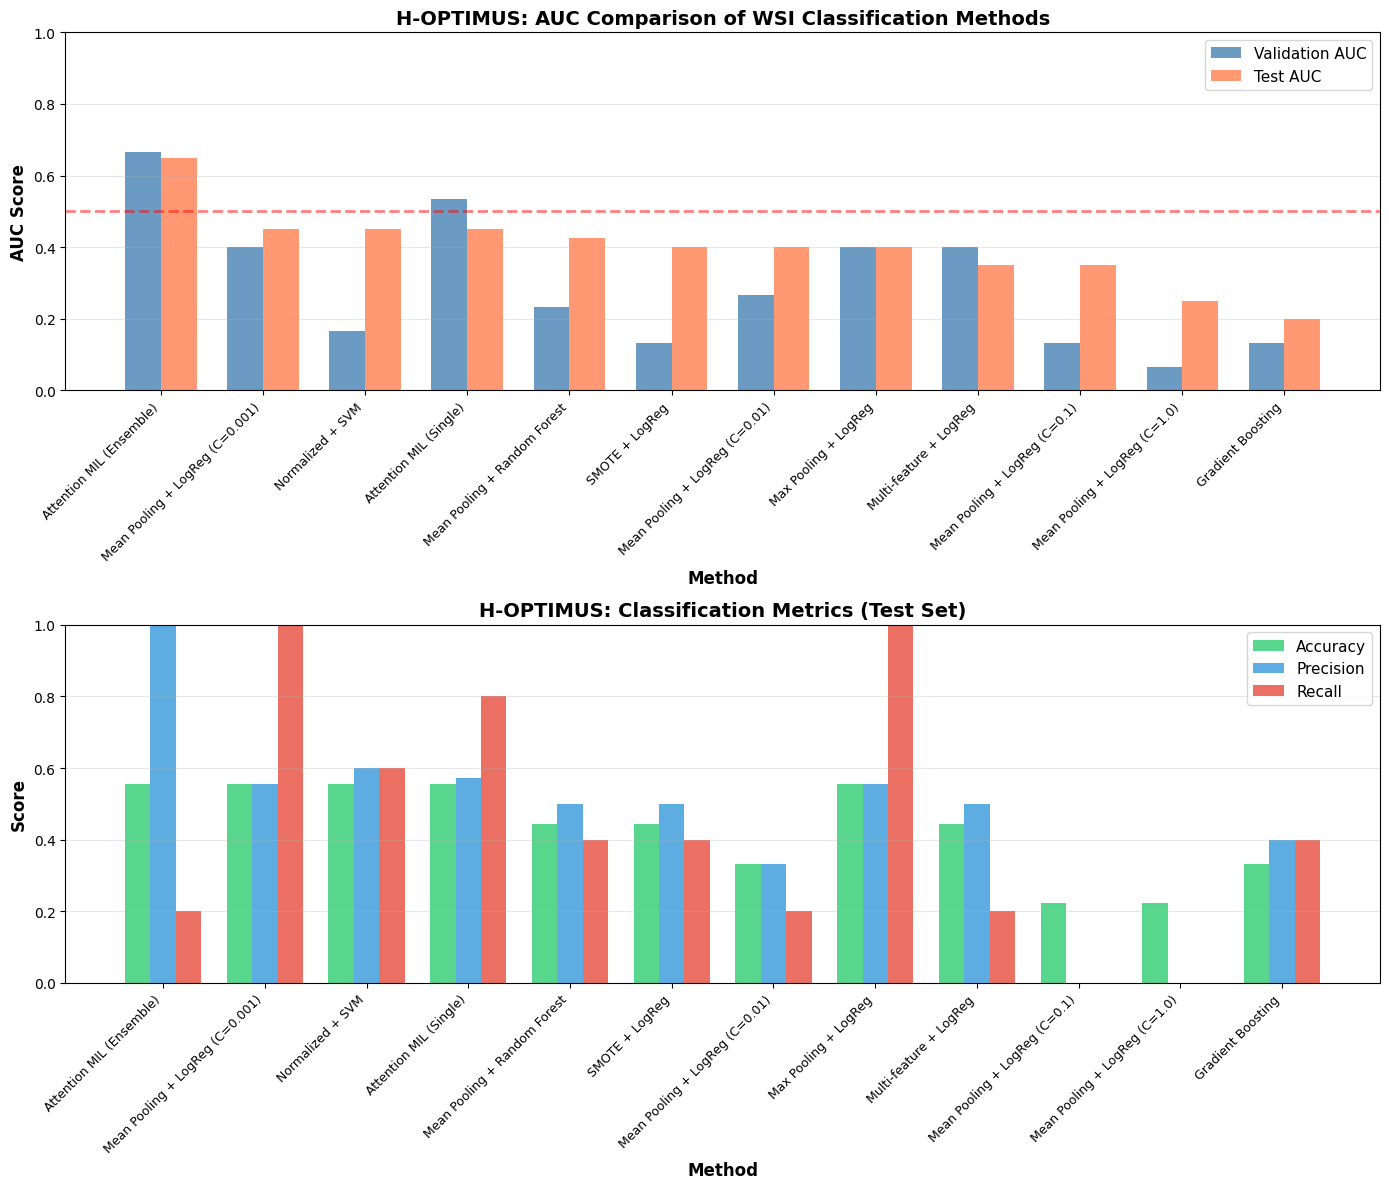

✓ Figure saved to: hoptimus_complete_comparison.png


In [27]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))


# Plot 1: AUC Comparison

x = np.arange(len(results_df))
width = 0.35

ax1.bar(
    x - width/2,
    results_df['val_auc'],
    width,
    label='Validation AUC',
    alpha=0.8,
    color='steelblue'
)

ax1.bar(
    x + width/2,
    results_df['test_auc'],
    width,
    label='Test AUC',
    alpha=0.8,
    color='coral'
)

ax1.set_xlabel('Method', fontsize=12, fontweight='bold')
ax1.set_ylabel('AUC Score', fontsize=12, fontweight='bold')
ax1.set_title(
    'H-OPTIMUS: AUC Comparison of WSI Classification Methods',
    fontsize=14,
    fontweight='bold'
)
ax1.set_xticks(x)
ax1.set_xticklabels(
    results_df['method'],
    rotation=45,
    ha='right',
    fontsize=9
)
ax1.legend(fontsize=11)
ax1.axhline(
    y=0.5,
    color='red',
    linestyle='--',
    linewidth=2,
    alpha=0.5,
    label='Random'
)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.0])


# Plot 2: Classification Metrics

width = 0.25
x = np.arange(len(results_df))

ax2.bar(
    x - width,
    results_df['test_acc'],
    width,
    label='Accuracy',
    alpha=0.8,
    color='#2ecc71'
)

ax2.bar(
    x,
    results_df['test_precision'],
    width,
    label='Precision',
    alpha=0.8,
    color='#3498db'
)

ax2.bar(
    x + width,
    results_df['test_recall'],
    width,
    label='Recall',
    alpha=0.8,
    color='#e74c3c'
)

ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title(
    'H-OPTIMUS: Classification Metrics (Test Set)',
    fontsize=14,
    fontweight='bold'
)
ax2.set_xticks(x)
ax2.set_xticklabels(
    results_df['method'],
    rotation=45,
    ha='right',
    fontsize=9
)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig(
    'hoptimus_complete_comparison.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

print("✓ Figure saved to: hoptimus_complete_comparison.png")


***Downloading Csv Files***

In [28]:
import os
from IPython.display import FileLink, display

files_to_download = [
    "hoptimus_method_comparison_full.csv",
    "hoptimus_auc_comparison.csv",
    "hoptimus_classification_metrics.csv"
]

for f in files_to_download:
    if os.path.exists(f):
        display(FileLink(f))
    else:
        print(f"File not found: {f}")



/kaggle/working/hoptimus_method_comparison_full.csv

/kaggle/working/hoptimus_auc_comparison.csv

/kaggle/working/hoptimus_classification_metrics.csv